In [1]:
import numpy as np
import pandas as pd
from scipy import integrate, optimize, stats, signal
import matplotlib.pyplot as plt

In [2]:
scale = 1e5

In [3]:
def GRM_ODE(t, C, r, p, K, a):
    return r*(np.power(C*scale, p)/scale)*(1-np.power(((C*scale)/(K*scale)), a))

In [4]:
def GRM(t, C0, r, p, K, a, rtol=1e-6):
    return integrate.solve_ivp(GRM_ODE, (t[0], t[-1]), [C0], t_eval=t, args=(r, p, K, a), rtol=rtol).y[0]

In [5]:
data = pd.read_json("https://epistat.sciensano.be/Data/COVID19BE_CASES_AGESEX.json")
data["DATE"] = pd.to_datetime(data["DATE"])

In [6]:
cases = data.groupby("DATE")["CASES"].sum().to_frame()
cases["index"] = (cases.index - cases.index[0])//pd.Timedelta("1d")
cases["cumsum"] = cases["CASES"].cumsum()
cases = cases.reset_index().rename(columns={"CASES": "daily", "DATE": "date"}).set_index("date")
cases["cs_mv14d"] = cases["cumsum"].rolling(14).mean().shift(-7)
cases["d_mv14d"] = cases["cs_mv14d"].diff()
cases["cs_savgol"] = signal.savgol_filter(cases["cumsum"], 31, 7)
cases["d_savgol"] = cases["cs_savgol"].diff()
cases.to_csv("covid.csv", index=False)
cases.sample(10)

,daily,index,cumsum,cs_mv14d,d_mv14d,cs_savgol,d_savgol
date,,,,,,,
2020-12-01,2682,275,586285,5.873602e+05,2184.571429,5.863419e+05,2136.368478
2021-11-02,11714,611,1392016,1.401315e+06,8705.000000,1.394094e+06,8130.527199
2021-12-05,5977,644,1864717,1.875826e+06,14751.285714,1.873278e+06,15145.749390
2020-03-21,469,20,4942,6.249214e+03,809.571429,5.103598e+03,781.564903
2020-05-08,483,68,53881,5.372621e+04,380.000000,5.368071e+04,399.779627
2021-03-30,5197,394,881884,8.829139e+05,4169.357143,8.822377e+05,4335.399116
2022-01-17,62712,687,2556144,2.612962e+06,42034.714286,2.567451e+06,43340.267708
2020-09-21,2202,204,107520,1.089515e+05,1614.500000,1.078749e+05,1433.452666
2021-01-10,808,315,665985,6.680782e+05,1913.214286,6.672218e+05,1923.531969


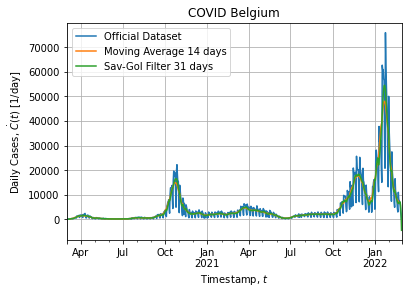

In [7]:
axe = cases["daily"].plot(label="Official Dataset")
cases["d_mv14d"].plot(ax=axe, label="Moving Average 14 days")
cases["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

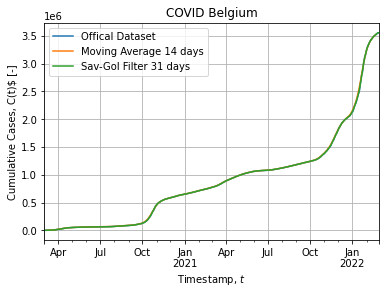

In [8]:
axe = cases["cumsum"].plot(label="Offical Dataset")
cases["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days")
cases["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.set_yscale("linear")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Cumulative Cases, C(t)$ [-]")
axe.grid()

In [9]:
t0 = "2021-12-21"
t1 = "2022-02-21"

In [10]:
peak = cases.loc[(cases.index >= t0) & (cases.index < t1), :]
for k in ["index", "cumsum", "cs_mv14d", "cs_savgol"]:
    peak[k + "_origin"] = peak[k] - peak[k][0]
peak.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,daily,index,cumsum,cs_mv14d,d_mv14d,cs_savgol,d_savgol,index_origin,cumsum_origin,cs_mv14d_origin,cs_savgol_origin
date,,,,,,,,,,,
2021-12-27,13297,666,2069584,2.084695e+06,10459.785714,2.070962e+06,8662.541650,6,42113,5.331057e+04,4.457457e+04
2022-01-10,37756,680,2332469,2.357764e+06,27829.142857,2.333002e+06,23218.059805,20,304998,3.263800e+05,3.066144e+05
2022-02-01,36730,702,3250307,3.243570e+06,29465.214286,3.250408e+06,29707.468320,42,1222836,1.212185e+06,1.224021e+06
2022-01-18,60712,688,2616856,2.657197e+06,44234.785714,2.614381e+06,46930.727636,28,589385,6.258129e+05,5.879941e+05
2021-12-28,12819,667,2082403,2.096637e+06,11942.000000,2.080854e+06,9891.635581,7,54932,6.525257e+04,5.446621e+04


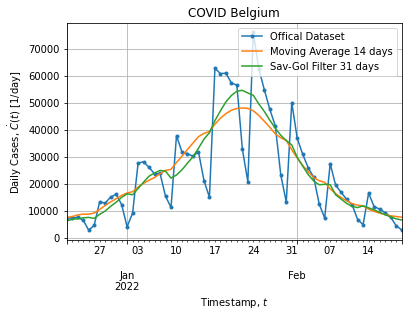

In [11]:
axe = peak["daily"].plot(linestyle="-", marker=".", label="Offical Dataset")
peak["d_mv14d"].plot(ax=axe, label="Moving Average 14 days")
peak["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

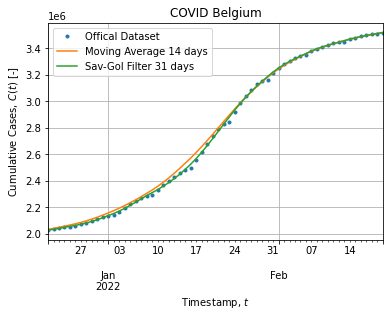

In [12]:
axe = peak["cumsum"].plot(marker=".", linestyle="none", label="Offical Dataset")
peak["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days")
peak["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Cumulative Cases, $C(t)$ [-]")
axe.grid()

In [13]:
popt, pcov = optimize.curve_fit(
    GRM, peak["index_origin"].values, peak["cumsum_origin"].values, p0=(2e4, 1.1, 0.8, 1.5e6, 1),
    bounds=([1, 0.1, 0.1, 50, 0.1], [1e7, 10, 1, 1e7, 10]),
    gtol=1e-9, max_nfev=10000
)
print(popt)

[1.97922688e+04 1.00000000e+01 8.11918538e-01 1.49449325e+06
 1.84386567e+00]


In [14]:
def resample(frame):
    sample = frame.copy()
    # Reindex:
    #sample = frame.set_index("index_origin")
    #index = np.linspace(sample.index.min(), sample.index.max(), 100)
    #sample = sample.reindex(index).interpolate().reset_index(drop=False)
    # Resample:
    sample = sample.sample(frac=1.0, replace=True).sort_index()
    # Deduplicate + Counts:
    count = sample.groupby(sample.index)["index"].count()
    count.name = "count"
    sample = sample.drop_duplicates().merge(count, left_index=True, right_index=True)
    sample = sample.sort_index()
    sample["sigma"] = np.sqrt(1/sample["count"])
    return sample
resample(peak).sample(5)

,daily,index,cumsum,cs_mv14d,d_mv14d,cs_savgol,d_savgol,index_origin,cumsum_origin,cs_mv14d_origin,cs_savgol_origin,count,sigma
date,,,,,,,,,,,,,
2022-02-11,12173,712,3439107,3.434208e+06,12634.857143,3.434701e+06,11598.492304,52,1411636,1.402824e+06,1.408314e+06,1,1.0
2022-01-29,23221,699,3150353,3.145549e+06,36972.857143,3.150413e+06,37889.794382,39,1122882,1.114165e+06,1.124026e+06,1,1.0
2022-01-28,41419,698,3127132,3.108576e+06,38424.071429,3.112524e+06,40524.013893,38,1099661,1.077192e+06,1.086136e+06,4,0.5
2022-02-04,22385,705,3329400,3.316979e+06,22283.928571,3.321233e+06,21003.672810,45,1301929,1.285594e+06,1.294845e+06,1,1.0
2022-02-05,12471,706,3341871,3.338086e+06,21106.785714,3.340822e+06,19589.309697,46,1314400,1.306701e+06,1.314435e+06,1,1.0


In [15]:
np.random.seed(123456789)

In [16]:
params = []
for i in range(50):
    # Resampling:
    sample = resample(peak)
    print(sample.shape[0])
    # Adjusting
    popt, pcov = optimize.curve_fit(
        GRM,
        sample["index_origin"].values, sample["cumsum_origin"].values/scale, sigma=sample["sigma"].values,
        p0=(2.2e4/scale, 1.0, 0.75, 1.5e6/scale, 2.1),
        bounds=([1/scale, 1e-2, 1e-2, 50/scale, 0.1], [1e5/scale, 10, 1, 1e7/scale, 10]),
        gtol=1e-9, max_nfev=50000
    )
    params.append(popt)
params = pd.DataFrame(params, columns=["C", "r", "p", "K", "a"])
#params.to_csv("bootstrap.csv", index=False)

40
39
40
37
38
41
40
42
40
38
39
38
43
39
38
34
37
37
40
38
41
40
38
37
42
38
43
38
39
39
34
34
43
38
38
43
38
38
38
38
36
41
38
39
44
43
40
45
43
42


In [17]:
#params = pd.read_csv("bootstrap_02.csv")

In [26]:
params.sample(5)

,C,r,p,K,a
28,0.201100,1.454607,0.790438,14.902248,2.074181
37,0.178113,2.989109,0.733751,14.821267,2.311137
30,0.152175,3.876090,0.710170,14.854453,2.550347
2,0.148979,2.343786,0.754557,14.952048,2.075658
36,0.144526,3.794995,0.712217,14.843242,2.590208


In [27]:
stats = params.describe()
stats

,C,r,p,K,a
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.197875,2.608973,0.764915,14.910444,2.129414
std,0.086719,1.515938,0.067833,0.076966,0.338779
min,0.094704,0.226374,0.677937,14.742007,1.218601
25%,0.148684,1.480297,0.716532,14.857876,1.958487
50%,0.170158,2.571500,0.746649,14.914919,2.145230
75%,0.217544,3.730612,0.790426,14.950929,2.343076
max,0.526261,6.257231,0.946022,15.117905,2.753649


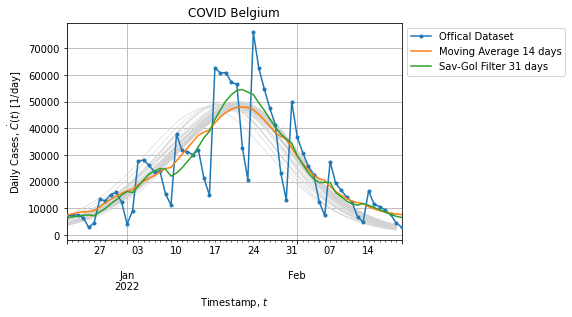

In [28]:
axe = peak["daily"].plot(linestyle="-", marker=".", label="Offical Dataset", zorder=1000)
for row in params.itertuples():
    c = GRM(peak["index"], *row[1:])*scale
    axe.plot(peak.index[:-1], np.diff(c), color="lightgrey", linewidth=0.6)
c = GRM(peak["index"], *popt)
#axe.plot(peak.index[:-1], np.diff(c), "-.", color="red", linewidth=1.35, label="Single Fit", zorder=2000)
peak["d_mv14d"].plot(ax=axe, label="Moving Average 14 days", zorder=1001)
peak["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days", zorder=1002)
axe.legend(bbox_to_anchor=(1,1), loc="upper left")
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

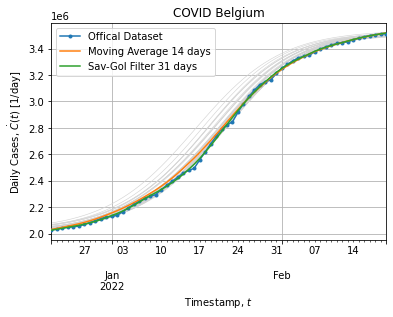

In [29]:
fig, axe = plt.subplots()
peak["cumsum"].plot(linestyle="-", marker=".", label="Offical Dataset", zorder=1000)
for row in params.itertuples():
    c = GRM(peak["index"], *row[1:])*scale + peak["cumsum"][0]
    axe.plot(peak.index, c, color="lightgrey", linewidth=0.6)
c = GRM(peak["index"], *popt) + peak["cumsum"][0]
#axe.plot(peak.index, c, "-.", color="red", linewidth=1.35, label="Single Fit", zorder=2000)
peak["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days", zorder=1001)
peak["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days", zorder=1002)
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

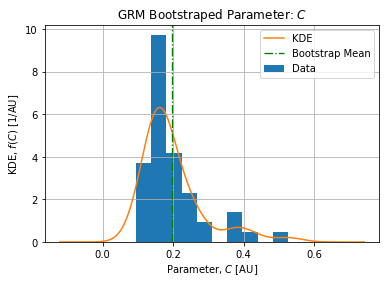

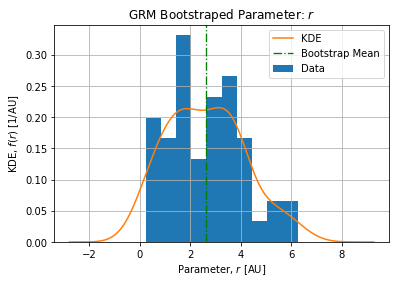

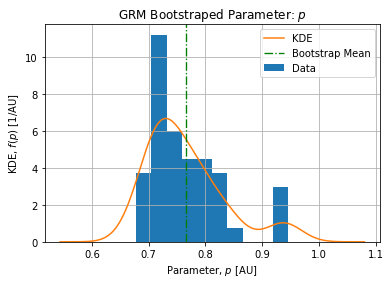

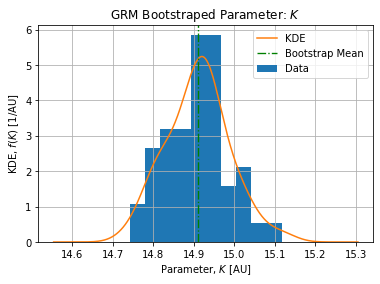

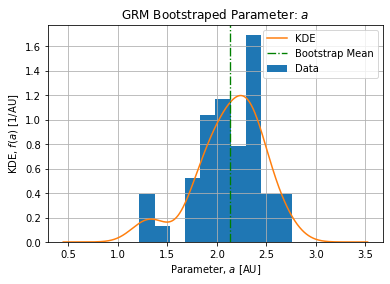

In [30]:
xm = params.mean()
for i, k in enumerate(params):
    fig, axe = plt.subplots()
    params[k].plot(kind="hist", ax=axe, label="Data", density=1)
    params[k].plot(kind="kde", ax=axe, label="KDE")
    axe.axvline(xm[i], linestyle="-.", color="green", linewidth=1.35, label="Bootstrap Mean")
    #axe.axvline(popt[i], linestyle="-.", color="red", linewidth=1.35, label="Single Fit")
    axe.legend()
    axe.set_title(r"GRM Bootstraped Parameter: $%s$" % k)
    axe.set_xlabel(r"Parameter, $%s$ [AU]" % k)
    axe.set_ylabel(r"KDE, $f(%s)$ [1/AU]" % k)
    axe.grid()

In [31]:
stats.loc["std",:]/stats.loc["mean",:]

C    0.438253
r    0.581048
p    0.088681
K    0.005162
a    0.159095
dtype: float64